In [1]:
%pip install --quiet datasets pandas transformers huggingface_hub ipywidgets

from datasets import load_dataset
import pandas as pd

dataset = load_dataset("mteb/tweet_sentiment_extraction")
df = pd.DataFrame(dataset['train'])

Note: you may need to restart the kernel to use updated packages.


README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [2]:
df.head(10)

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,1,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,2,positive
7,50e14c0bb8,Soooo high,1,neutral
8,e050245fbd,Both of you,1,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,2,positive


AutoTokenizer is a special class in the Huggingface Transformers library. It helps you choose the right tokenizer for your model without knowing the details.

Think of it as a smart assistant that knows which tool to use for the job.

The AutoTokenizer is easy to use. You don’t have to remember which tokenizer goes with which model. It ensures you use the correct tokenizer for the model, reducing errors and improving consistency.

Autotokenizer is flexible. It works with many different models, allowing you to switch models without changing much code.

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import login
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

# Load environment variables from a .env file
# load_dotenv()

# Retrieve the token from the environment variables
# token = os.getenv("HF_TOKEN")
token = secret_value_0

try:
    login(token=token)
    print("Logged in to Hugging Face Hub")
except Exception as e:
    print(f"Error during login: {e}")
    print("Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

HF_MODEL_NAME = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
print("Loaded Tokenizer")
base_model = AutoModelForSequenceClassification.from_pretrained(HF_MODEL_NAME, num_labels=3)    
print("Loaded Model")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Logged in to Hugging Face Hub


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Loaded Tokenizer


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Model


In [4]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

#### Tokenize and Encode Text

In [5]:
# Setting the pad token. By default, LLaMA models do not have a pad token, so we need to set it manually.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    # padding set make the batches equal to the value set in max_length 
    # truncation set to True to truncate the text if it exceeds max_length
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
# print(tokenized_datasets)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Map:   0%|          | 0/27481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

### Evaluate

In [6]:
%pip install --quiet evaluate
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   return metric.compute(predictions=predictions, references=labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


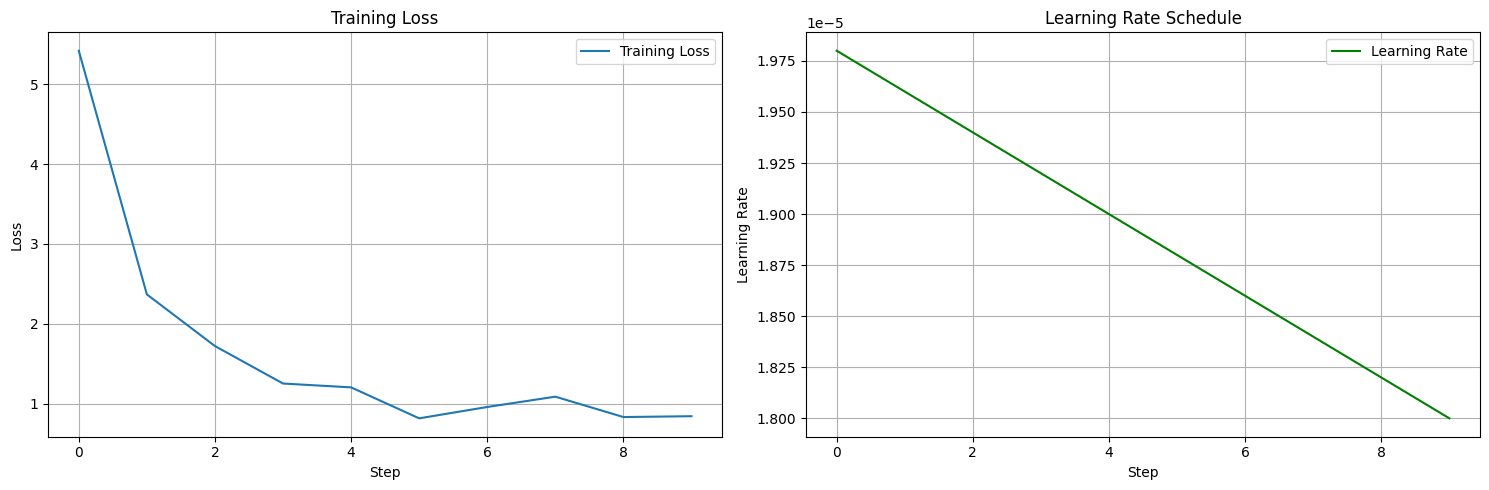

Current step: 9/1000
Current loss: 0.8447
Current learning rate: 0.00001800


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
from transformers import TrainingArguments, Trainer, TrainerCallback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Custom callback to visualize training progress
class ProgressVisualizationCallback(TrainerCallback):  # Inherit from TrainerCallback
    def __init__(self):
        self.training_logs = []
    
    def on_train_begin(self, args, state, control, **kwargs):
        # Initialize at the beginning of training
        self.training_logs = []
        print("Training started!")
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            self.training_logs.append(logs)
            # Plot every 10 logs to avoid slowing down training
            if len(self.training_logs) % 10 == 0:
                self.visualize_progress(state)
    
    def visualize_progress(self, state):
        clear_output(wait=True)
        
        # Extract metrics
        steps = [log.get('step', i) for i, log in enumerate(self.training_logs) if 'loss' in log]
        loss = [log['loss'] for log in self.training_logs if 'loss' in log]
        lr = [log['learning_rate'] for log in self.training_logs if 'learning_rate' in log]
        
        # Create plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        ax1.plot(steps, loss, label='Training Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Learning rate plot
        ax2.plot(steps, lr, label='Learning Rate', color='green')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Learning Rate')
        ax2.set_title('Learning Rate Schedule')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print current stats
        if steps:
            print(f"Current step: {steps[-1]}/{state.max_steps}")
            print(f"Current loss: {loss[-1]:.4f}")
            print(f"Current learning rate: {lr[-1]:.8f}")
            
            # Calculate training speed
            if len(steps) > 10:
                recent_steps = steps[-10:]
                if len(recent_steps) > 1 and state.max_steps:
                    steps_per_log = recent_steps[1] - recent_steps[0]
                    remaining_steps = state.max_steps - steps[-1]
                    steps_to_go = max(0, remaining_steps)
                    estimated_logs = steps_to_go / steps_per_log if steps_per_log else 0
                    print(f"Approximately {estimated_logs:.0f} logs remaining")

# Setup training with proper logging
training_args = TrainingArguments(
    output_dir="test_trainer",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="steps",
    eval_steps=100,    # Evaluate every 100 steps
    save_strategy="steps",
    save_steps=500,    # Save model every 100 steps
    save_only_model=True,  # Only save model weights, not optimizer state
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=1000,    # Set a specific number of steps
    report_to="none",  # Disable wandb/tensorboard to avoid conflicts
    learning_rate=2e-5,
    weight_decay=0.01,
)

# Create the trainer with our callback
progress_callback = ProgressVisualizationCallback()
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[progress_callback],  # Add the callback here
)

# Start training
print("Starting training...")
trainer.train()